# Dask in HEP analyses

### Warning: In this talk we will assume some familiarity with the uproot+awkward way of dealing with data.

Dask provides an interface for specifying/locating input data and then describing manipulations on that data are organized into a task graph. This task graph can then be executed on local compute or on a cluster. Dask Array and Dask Dataframe deal well with rectangular data. They provide a scalable interface to describe manipulations of data that may not fit into
system memory by mapping transformations onto partitions of the data that fit in memory.

<img src="https://docs.dask.org/en/stable/_images/dask-overview.svg" width="400" style="margin-right: 20px;"><img src="https://docs.dask.org/en/latest/_images/dask-array.svg" width="400">

But in physics we're dealing with [jagged or ragged arrays](https://en.wikipedia.org/wiki/Jagged_array). A ragged array is something like this:

```
[[1, 2, 3],
 [4],
 [],
 [5, 6]]
---------------------
type: 4 * var * int64
```

In the pythonic HEP ecosystem, we deal with those kinds of arrays using [awkward](https://github.com/scikit-hep/awkward). Awkward Arrays are general tree-like data structures, like JSON, but contiguous in memory and operated upon with compiled, vectorized code like NumPy. For more information, please visit the [awkward array docs](https://awkward-array.org/doc/main/index.html) and/or see [previous talks from Jim Pivarski](https://github.com/jpivarski-talks/).

### How jagged arrays and histogramming are integrated with dask: awkward array 2.0, dask_awkward, dask_histogram, and coffea

<img src="img/coffea-upgrade.png" width="600">

Awkward array 2.0 features an improved and streamlined backend with. The backend is using only C and python without any C++ metadata handling. `ak.virtual` delayed computations are replaced by [dask-awkward](https://github.com/dask-contrib/dask-awkward).

`dask_awkward` and `dask_histogram` bring delayed, distributed computation to `awkward array 2.0` based analyses and libraries. [Uproot](https://github.com/scikit-hep/uproot5) now provides lazy reading of data via [uproot.dask](https://uproot.readthedocs.io/en/latest/uproot._dask.dask.html).

#### Our partitions are split on the event axis since each event is independent and we never run computations that combine more than 1 events.

All that provides access to dask at all layers of analysis which yields improved parallelism and better factorization away from compute infrastructure.
Coffea, and `NanoEvents` in particular which was almost entirely based on `ak.virtual`, now leverage all this infrastructure.

Please see [Lindsey's CHEP 2023 talk](https://indico.jlab.org/event/459/contributions/11533/attachments/9496/13762/CoffeaCHEP_LindseyGray_09052023.pdf) for more info on those upgrades and also see the most recent talks from [Lindsey](https://indico.cern.ch/event/1383972/contributions/5825304/) and [Jim](https://github.com/jpivarski-talks/2023-07-24-tac-hep-tutorial/blob/main/horizontal.ipynb).


In [1]:
import dask
from dask.threaded import get
from dask.local import get_sync
from dask.optimization import cull, inline, inline_functions, fuse

def print_and_return(string):
    print(string)
    return string

def format_str(count, val, nwords):
    return (f'word list has {count} occurrences of '
            f'{val}, out of {nwords} words')

dsk = {'words': 'apple orange apple pear orange pear pear',
       'nwords': (len, (str.split, 'words')),
       'val1': 'orange',
       'val2': 'apple',
       'val3': 'pear',
       'count1': (str.count, 'words', 'val1'),
       'count2': (str.count, 'words', 'val2'),
       'count3': (str.count, 'words', 'val3'),
       'format1': (format_str, 'count1', 'val1', 'nwords'),
       'format2': (format_str, 'count2', 'val2', 'nwords'),
       'format3': (format_str, 'count3', 'val3', 'nwords'),
       'print1': (print_and_return, 'format1'),
       'print2': (print_and_return, 'format2'),
       'print3': (print_and_return, 'format3')}

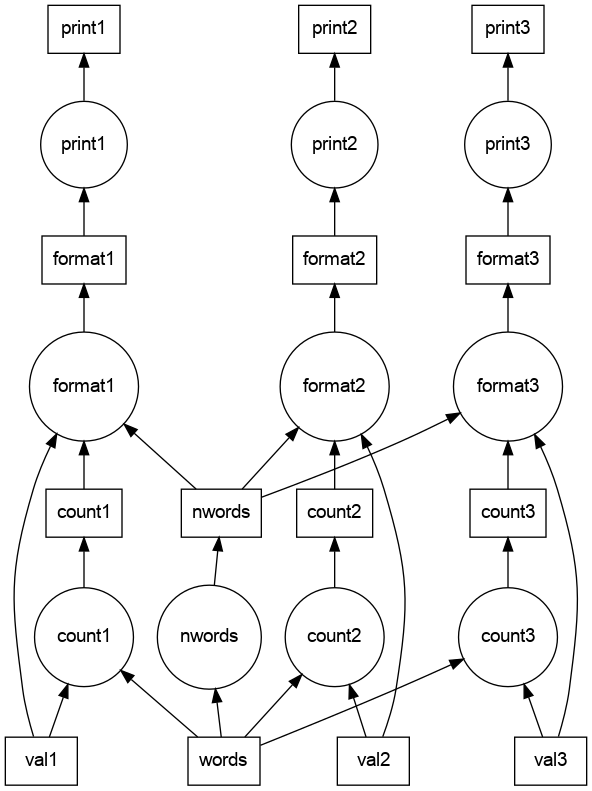

In [2]:
dask.base.visualize_dsk(dsk, verbose=True)

word list has 2 occurrences of orange, out of 7 words
word list has 2 occurrences of apple, out of 7 words


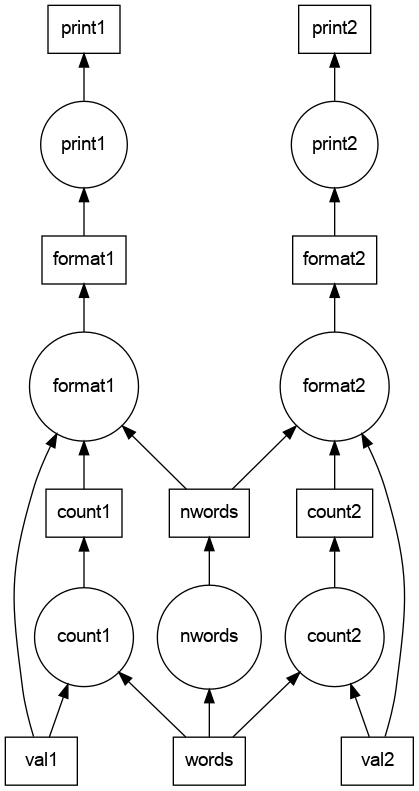

In [3]:
outputs = ['print1', 'print2']
dsk1, dependencies = cull(dsk, outputs)  # remove unnecessary tasks from the graph

results = get_sync(dsk1, outputs)

dask.base.visualize_dsk(dsk1, verbose=True)

word list has 2 occurrences of orange, out of 7 words
word list has 2 occurrences of apple, out of 7 words


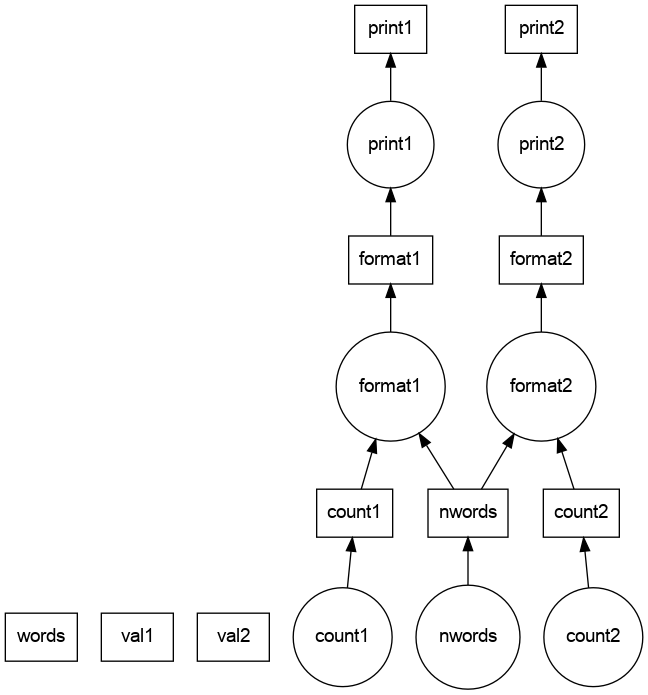

In [4]:
dsk2 = inline(dsk1, dependencies=dependencies)
results = get_sync(dsk2, outputs)

dask.base.visualize_dsk(dsk2, verbose=True)

word list has 2 occurrences of orange, out of 7 words
word list has 2 occurrences of apple, out of 7 words


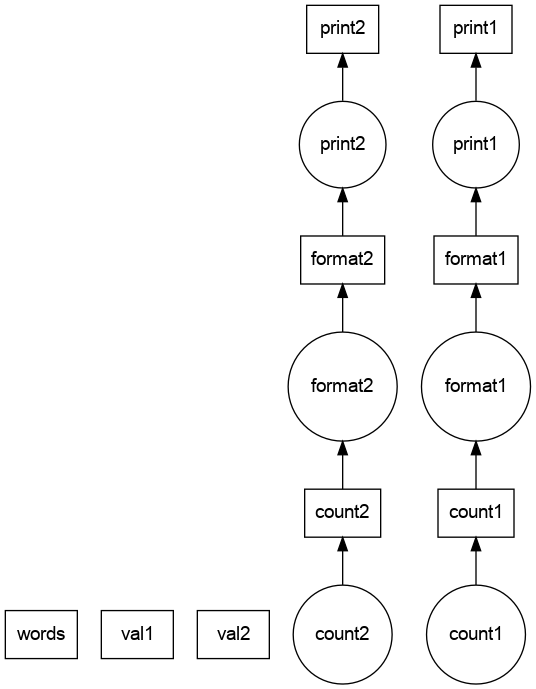

In [5]:
dsk3 = inline_functions(dsk2, outputs, [len, str.split], dependencies=dependencies)
results = get_sync(dsk3, outputs)

dask.base.visualize_dsk(dsk3, verbose=True)

word list has 2 occurrences of orange, out of 7 words
word list has 2 occurrences of apple, out of 7 words


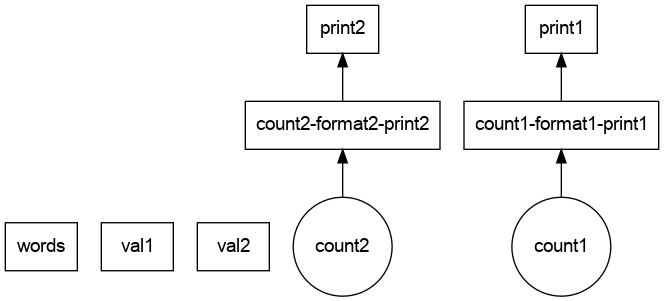

In [6]:
dsk4, dependencies = fuse(dsk3)
results = get_sync(dsk4, outputs)

dask.base.visualize_dsk(dsk4, verbose=True)

In [7]:
def optimize(dsk, keys):
    dsk1, deps = cull(dsk, keys)
    dsk2 = inline(dsk1, dependencies=deps)
    dsk3 = inline_functions(dsk2, keys, [len, str.split],
                            dependencies=deps)
    dsk4, deps = fuse(dsk3)
    return dsk4, deps

def optimize_and_get(dsk, keys):    
    dsk4, deps = fuse(dsk, keys)
    return get(dsk4, keys)

optimize_and_get(dsk, outputs)

word list has 2 occurrences of orange, out of 7 words
word list has 2 occurrences of apple, out of 7 words
word list has 3 occurrences of pear, out of 7 words


('word list has 2 occurrences of orange, out of 7 words',
 'word list has 2 occurrences of apple, out of 7 words')

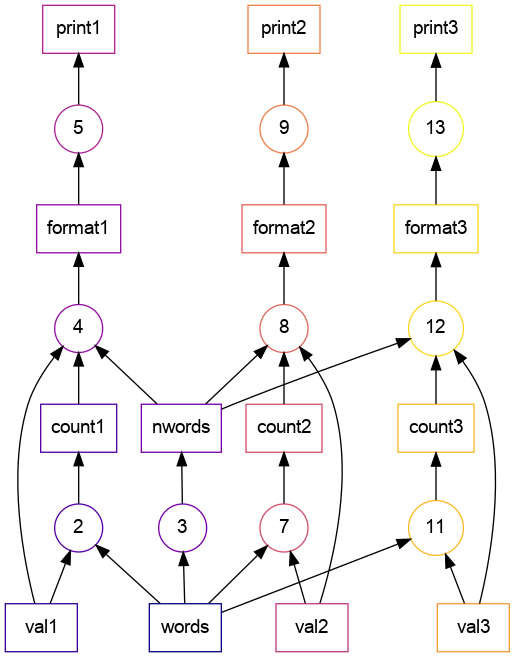

In [8]:
dask.base.visualize_dsk(dsk, verbose=True, color="order")

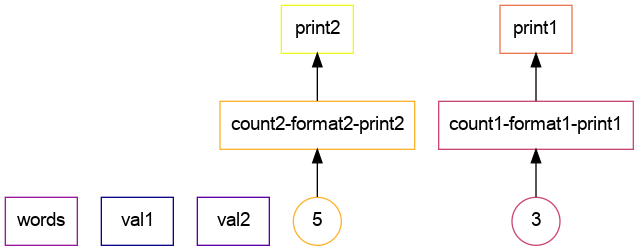

In [9]:
dsk5, _ = optimize(dsk, outputs)

dask.base.visualize_dsk(dsk5, verbose=True, color="order")

In [10]:
import time

import awkward as ak
import hist
import matplotlib.pyplot as plt
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor

import dask
import dask_awkward as dak
import hist.dask as hda

# The opendata files are non-standard NanoAOD, so some optional data columns are missing
NanoAODSchema.warn_missing_crossrefs = False

# The warning emitted below indicates steps_per_file is for initial data exploration
# and test. When running at scale there are better ways to specify processing chunks
# of files.
events, report = NanoEventsFactory.from_root(
    {"https://github.com/CoffeaTeam/coffea/raw/master/tests/samples/nano_dy.root": "Events"},
    metadata={"dataset": "Test"},
    uproot_options={"allow_read_errors_with_report": True},
).events()

/depot/cms/kernels/hats2024/lib/python3.12/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


# Query 1

Plot the <i>E</i><sub>T</sub><sup>miss</sup> of all events.

{'from-uproot-42acb4bd8beb817b2c5d4951b3670613': frozenset({'MET_pt'})}

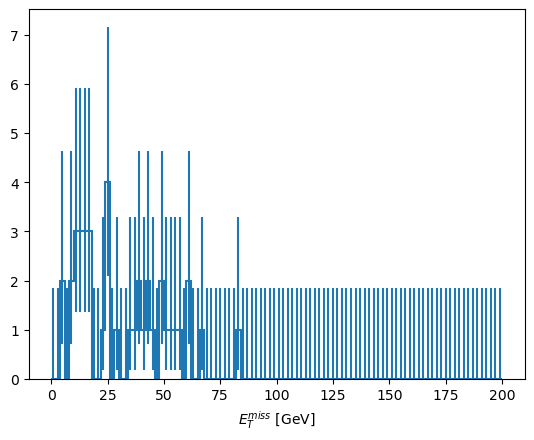

In [11]:
q1_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]")
    .Double()
    .fill(events.MET.pt)
)

dask.compute(q1_hist, report)[0].plot1d(flow="none")
dak.necessary_columns(q1_hist)

# Query 2
Plot the <i>p</i><sub>T</sub> of all jets.

{'from-uproot-42acb4bd8beb817b2c5d4951b3670613': frozenset({'Jet_pt', 'nJet'})}

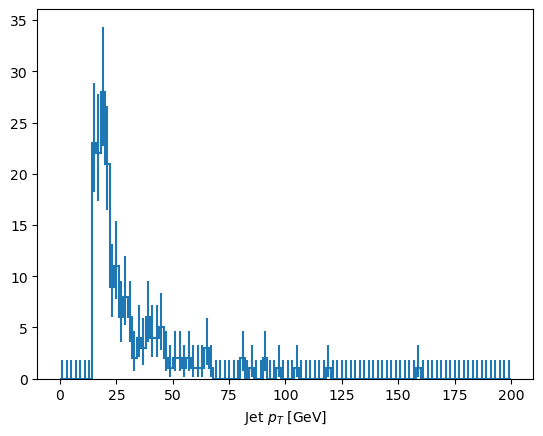

In [12]:
q2_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="ptj", label="Jet $p_{T}$ [GeV]")
    .Double()
    .fill(ak.flatten(events.Jet.pt))
)


q2_hist.compute().plot1d(flow="none")
dak.necessary_columns(q2_hist)

# Query 3
Plot the <i>p</i><sub>T</sub> of jets with |<i>η</i>| < 1.

{'from-uproot-42acb4bd8beb817b2c5d4951b3670613': frozenset({'Jet_eta',
            'Jet_pt',
            'nJet'})}

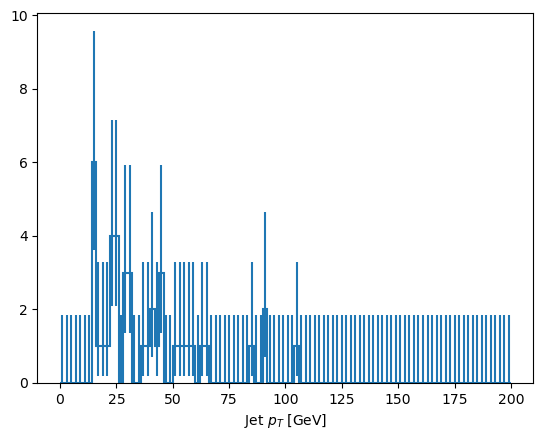

In [13]:
q3_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="ptj", label="Jet $p_{T}$ [GeV]")
    .Double()
    .fill(ak.flatten(events.Jet[abs(events.Jet.eta) < 1].pt))
)

q3_hist.compute().plot1d(flow="none")
dak.necessary_columns(q3_hist)

# Query 4
Plot the <i>E</i><sub>T</sub><sup>miss</sup> of events that have at least two jets with <i>p</i><sub>T</sub> > 40 GeV.

{'from-uproot-42acb4bd8beb817b2c5d4951b3670613': frozenset({'Jet_pt',
            'MET_pt',
            'nJet'})}

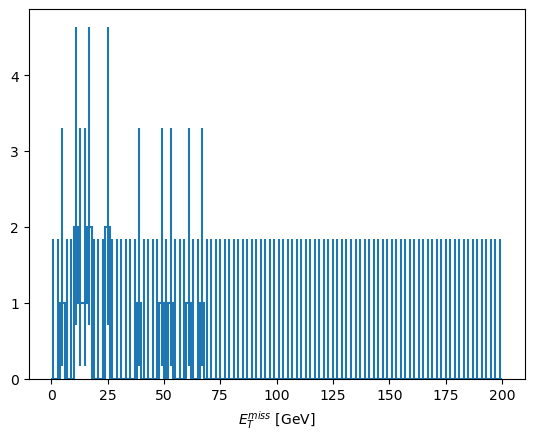

In [14]:
has2jets = ak.sum(events.Jet.pt > 40, axis=1) >= 2
q4_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]")
    .Double()
    .fill(events[has2jets].MET.pt)
)

q4_hist.compute().plot1d(flow="none")
dak.necessary_columns(q4_hist)

# Query 5
Plot the <i>E</i><sub>T</sub><sup>miss</sup> of events that have an
opposite-charge muon pair with an invariant mass between 60 and 120 GeV.

{'from-uproot-42acb4bd8beb817b2c5d4951b3670613': frozenset({'MET_pt',
            'Muon_charge',
            'Muon_eta',
            'Muon_mass',
            'Muon_phi',
            'Muon_pt',
            'nMuon'})}

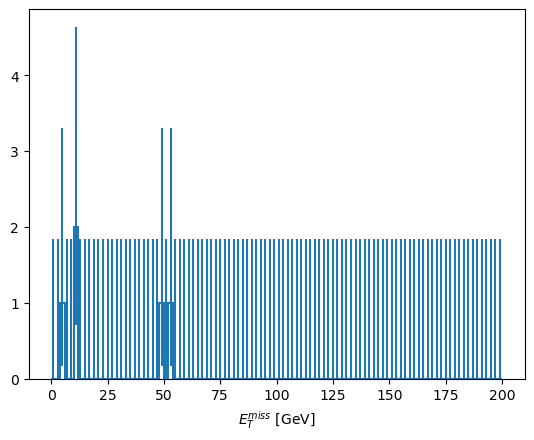

In [15]:
mupair = ak.combinations(events.Muon, 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
goodevent = ak.any(
    (pairmass > 60)
    & (pairmass < 120)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)
q5_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]")
    .Double()
    .fill(events[goodevent].MET.pt)
)


q5_hist.compute().plot1d(flow="none")
dak.necessary_columns(q5_hist)

# Query 6
For events with at least three jets, plot the <i>p</i><sub>T</sub> of the trijet four-momentum that has the invariant mass closest to 172.5 GeV in each event and plot the maximum <i>b</i>-tagging discriminant value among the jets in this trijet.

{'from-uproot-42acb4bd8beb817b2c5d4951b3670613': frozenset({'Jet_btagDeepB',
            'Jet_eta',
            'Jet_mass',
            'Jet_phi',
            'Jet_pt',
            'nJet'})}

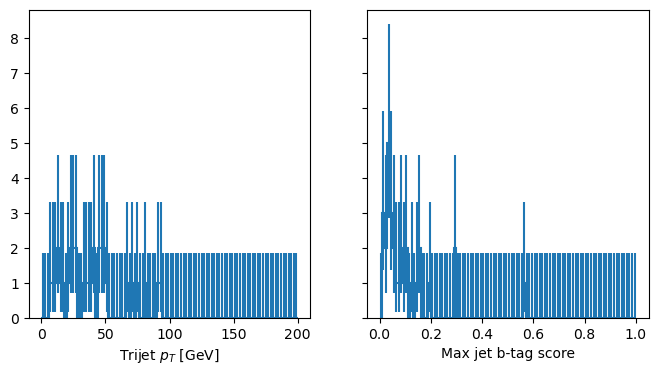

In [16]:
jets = ak.zip(
    {k: getattr(events.Jet, k) for k in ["x", "y", "z", "t", "btagDeepB"]},
    with_name="LorentzVector",
    behavior=events.Jet.behavior,
)
trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])
trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3
trijet = ak.flatten(
    trijet[ak.singletons(ak.argmin(abs(trijet.p4.mass - 172.5), axis=1))]
)
maxBtag = np.maximum(
    trijet.j1.btagDeepB,
    np.maximum(
        trijet.j2.btagDeepB,
        trijet.j3.btagDeepB,
    ),
)
q6_hists = {
    "trijetpt": hda.Hist.new.Reg(
        100, 0, 200, name="pt3j", label="Trijet $p_{T}$ [GeV]"
    )
    .Double()
    .fill(trijet.p4.pt),
    "maxbtag": hda.Hist.new.Reg(
        100, 0, 1, name="btagDeepB", label="Max jet b-tag score"
    )
    .Double()
    .fill(maxBtag),
}

out = dask.compute(q6_hists, report)[0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
out["trijetpt"].plot1d(ax=ax1, flow="none")
out["maxbtag"].plot1d(ax=ax2, flow="none")
dak.necessary_columns(q6_hists)

# Query 7
Plot the scalar sum in each event of the <i>p</i><sub>T</sub> of jets with <i>p</i><sub>T</sub> > 30 GeV that are not within 0.4 in Δ<i>R</i> of any light lepton with <i>p</i><sub>T</sub> > 10 GeV.

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_107468/1223953584.py:13: SyntaxWarning: invalid escape sequence '\s'
  100, 0, 200, name="sumjetpt", label="Jet $\sum p_{T}$ [GeV]"


{'from-uproot-42acb4bd8beb817b2c5d4951b3670613': frozenset({'Electron_eta',
            'Electron_phi',
            'Electron_pt',
            'Jet_eta',
            'Jet_phi',
            'Jet_pt',
            'Muon_eta',
            'Muon_phi',
            'Muon_pt',
            'nElectron',
            'nJet',
            'nMuon'})}

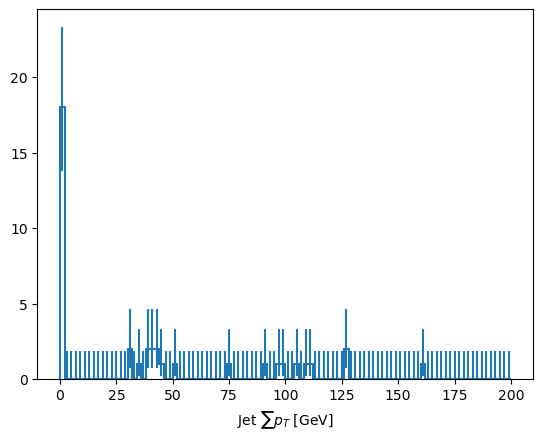

In [17]:
cleanjets = events.Jet[
    ak.all(
        events.Jet.metric_table(events.Muon[events.Muon.pt > 10]) >= 0.4, axis=2
    )
    & ak.all(
        events.Jet.metric_table(events.Electron[events.Electron.pt > 10]) >= 0.4,
        axis=2,
    )
    & (events.Jet.pt > 30)
]
q7_hist = (
    hda.Hist.new.Reg(
        100, 0, 200, name="sumjetpt", label="Jet $\sum p_{T}$ [GeV]"
    )
    .Double()
    .fill(ak.sum(cleanjets.pt, axis=1))
)

q7_hist.compute().plot1d(flow="none")
dak.necessary_columns(q7_hist)

# Query 8
For events with at least three light leptons and a same-flavor opposite-charge light lepton pair, find such a pair that has the invariant mass closest to 91.2 GeV in each event and plot the transverse mass of the system consisting of the missing tranverse momentum and the highest-<i>p</i><sub>T</sub> light lepton not in this pair.

<>:34: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_107468/1511217464.py:34: SyntaxWarning: invalid escape sequence '\e'
  100, 0, 200, name="mt", label="$\ell$-MET transverse mass [GeV]"


{'from-uproot-42acb4bd8beb817b2c5d4951b3670613': frozenset({'Electron_charge',
            'Electron_eta',
            'Electron_mass',
            'Electron_phi',
            'Electron_pt',
            'MET_phi',
            'MET_pt',
            'Muon_charge',
            'Muon_eta',
            'Muon_mass',
            'Muon_phi',
            'Muon_pt',
            'nElectron',
            'nMuon'})}

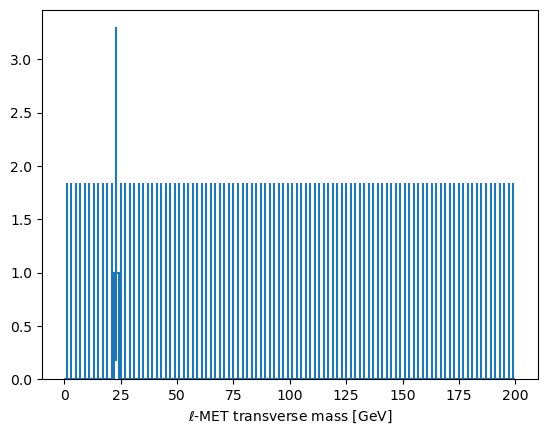

In [18]:
events["Electron", "pdgId"] = -11 * events.Electron.charge
events["Muon", "pdgId"] = -13 * events.Muon.charge
events["leptons"] = ak.concatenate(
    [events.Electron, events.Muon],
    axis=1,
)
events = events[ak.num(events.leptons) >= 3]
pair = ak.argcombinations(events.leptons, 2, fields=["l1", "l2"])
pair = pair[(events.leptons[pair.l1].pdgId == -events.leptons[pair.l2].pdgId)]

pair = pair[
    ak.singletons(
        ak.argmin(
            abs(
                (events.leptons[pair.l1] + events.leptons[pair.l2]).mass
                - 91.2
            ),
            axis=1,
        )
    )
]

events = events[ak.num(pair) > 0]
pair = pair[ak.num(pair) > 0][:, 0]

l3 = ak.local_index(events.leptons)
l3 = l3[(l3 != pair.l1) & (l3 != pair.l2)]
l3 = l3[ak.argmax(events.leptons[l3].pt, axis=1, keepdims=True)]
l3 = events.leptons[l3][:, 0]

mt = np.sqrt(2 * l3.pt * events.MET.pt * (1 - np.cos(events.MET.delta_phi(l3))))
q8_hist = (
    hda.Hist.new.Reg(
        100, 0, 200, name="mt", label="$\ell$-MET transverse mass [GeV]"
    )
    .Double()
    .fill(mt)
)

q8_hist.compute().plot1d(flow="none")
dak.necessary_columns(q8_hist)